# 📁 Create a Test Codebase

This step creates a folder named **`test_code`** that will serve as a mock codebase.

We'll use this folder to store sample **`.py`** files for testing our dependency graph builder and code summarization agent.

➡️ Run the next code cell to create the folder.

---



In [15]:
!pip install --upgrade together networkx matplotlib


# **TASK 1**

---



In [2]:
!sudo apt-get install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [4]:
!sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 29 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB o

In [5]:
!pip install pygraphviz


  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-linux_x86_64.whl size=169714 sha256=8f025fd57007ceed5c1485b3aa430d1a391d9fe81b63a6ec68c0c16544bfb531
  Stored in directory: /root/.cache/pip/wheels/9c/5f/df/6fffd2a4353f26dbb0e3672a1baf070c124a1d74a5f9318279
Successfully built pygraphviz


In [8]:
import os
import ast
import re
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Set, Optional
from together import Together
import json
import pygraphviz as pgv

class CodebaseAnalyzer:
    def __init__(self, directory: str, api_key: Optional[str] = None):
        """
        Initialize the analyzer with the directory to scan and optional API key.

        Args:
            directory: Root directory of the codebase to analyze
            api_key: Together.ai API key (optional - will use env var if not provided)
        """
        self.directory = Path(directory)
        self.api_key = api_key or os.environ.get("TOGETHER_API_KEY")
        self.together_client = Together(api_key=self.api_key) if self.api_key else None
        self.module_mapping = {}  # Maps module names to file paths
        self.package_structure = {}  # Maps package paths to their modules

    def analyze(self, max_files: int = None, skip_llm: bool = False):
        """
        Analyze the codebase and return a dependency graph.

        Args:
            max_files: Optional limit on number of files to process
            skip_llm: If True, skip the LLM analysis step

        Returns:
            NetworkX DiGraph representing the dependency relationships
        """
        # Step 1: Identify Python files and build package structure
        python_files = self._get_python_files(max_files)
        self._build_package_structure(python_files)

        # Step 2: Static analysis
        static_dependencies = {}
        for file in python_files:
            imports, exports = self._extract_static_imports_and_exports(file)
            static_dependencies[file] = {'imports': imports, 'exports': exports}

        # Step 3: Dynamic analysis (optional)
        llm_dynamic_dependencies = {}
        if not skip_llm and self.together_client:
            for file in python_files:
                with open(file, 'r', encoding='utf-8', errors='ignore') as f:
                    code = f.read()
                dynamic_analysis = self._analyze_with_llm(code)
                llm_dynamic_dependencies[file] = dynamic_analysis

        # Step 4: Build dependency graph
        G = self._build_dependency_graph(static_dependencies, llm_dynamic_dependencies)
        return G

    def _get_python_files(self, max_files: Optional[int] = None) -> List[str]:
        """Recursively get Python files in the directory with optional limit."""
        python_files = []

        # Skip common directories that aren't part of the source code
        skip_dirs = {'.git', '.venv', 'venv', 'env', '__pycache__', 'node_modules', 'dist', 'build'}

        for root, dirs, files in os.walk(self.directory):
            # Modify dirs in place to skip certain directories
            dirs[:] = [d for d in dirs if d not in skip_dirs]

            for file in files:
                if file.endswith('.py'):
                    file_path = os.path.join(root, file)
                    python_files.append(file_path)

                    # Check if we've reached the limit
                    if max_files and len(python_files) >= max_files:
                        return python_files

        return python_files

    def _build_package_structure(self, python_files: List[str]) -> None:
        """
        Build a mapping of Python packages and modules to help resolve import statements.
        """
        base_dir = str(self.directory)

        # First pass: identify all potential modules
        for file_path in python_files:
            if os.path.basename(file_path) == "__init__.py":
                # This is a package
                rel_path = os.path.relpath(os.path.dirname(file_path), base_dir)
                package_name = rel_path.replace(os.sep, '.')
                self.module_mapping[package_name] = file_path

                # Also map submodules
                parts = package_name.split('.')
                for i in range(1, len(parts)+1):
                    partial_pkg = '.'.join(parts[:i])
                    if partial_pkg not in self.module_mapping:
                        self.module_mapping[partial_pkg] = file_path
            else:
                # This is a module
                rel_path = os.path.relpath(file_path, base_dir)
                module_path = os.path.splitext(rel_path)[0].replace(os.sep, '.')
                self.module_mapping[module_path] = file_path

    def _extract_static_imports_and_exports(self, filepath: str) -> Tuple[List[str], List[str]]:
        """
        Extract static imports and exports from a Python file using AST.

        Returns:
            Tuple of (imports, exports)
        """
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
            try:
                code = file.read()
                tree = ast.parse(code)
            except SyntaxError:
                print(f"Syntax error in {filepath}, skipping")
                return [], []

        imports = []
        exports = []

        # Extract imports
        for node in ast.walk(tree):
            if isinstance(node, ast.Import):
                for alias in node.names:
                    imports.append(alias.name)
            elif isinstance(node, ast.ImportFrom):
                module = node.module or ''
                for alias in node.names:
                    if alias.name == '*':
                        imports.append(f"{module}.*")
                    else:
                        imports.append(f"{module}.{alias.name}")

        # Extract exports (functions, classes, and global variables)
        for node in ast.iter_child_nodes(tree):
            if isinstance(node, ast.FunctionDef):
                exports.append(node.name)
            elif isinstance(node, ast.ClassDef):
                exports.append(node.name)
            elif isinstance(node, ast.Assign):
                for target in node.targets:
                    if isinstance(target, ast.Name):
                        exports.append(target.id)

        return imports, exports

    def _analyze_with_llm(self, code: str) -> List[str]:
        """
        Use Together.ai's LLM to analyze code for dynamic imports or complex dependencies.

        Returns:
            List of dynamic dependencies detected
        """
        if not self.together_client:
            return []

        prompt = f"""Analyze this Python code and identify:
1. Any dynamic imports (using importlib, __import__, exec, etc.)
2. Any implicit dependencies not visible in static imports
3. Any complex dependencies hidden in string literals or config files

Only list the actual module names, one per line. If none, respond with "None".

```python
{code}
```"""

        try:
            response = self.together_client.chat.completions.create(
                model="meta-llama/Llama-3-8b-chat-hf",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=1000
            )
            result = response.choices[0].message.content

            # Parse the result to extract only module names
            dynamic_deps = []
            for line in result.split('\n'):
                # Remove bullets, numbers, and other formatting
                clean_line = re.sub(r'^[•\-*\d.\s]+', '', line.strip())
                if clean_line and "None" not in clean_line and len(clean_line) > 2:
                    # Extract potential module name
                    match = re.search(r'([a-zA-Z0-9_\.]+)', clean_line)
                    if match:
                        module = match.group(1)
                        dynamic_deps.append(module)

            return dynamic_deps
        except Exception as e:
            print(f"Error in LLM analysis: {e}")
            return []

    def _build_dependency_graph(self, static_data: Dict, llm_data: Dict) -> nx.DiGraph:
        """
        Combine static and LLM results to create a dependency graph.
        """
        G = nx.DiGraph()

        # Add nodes for all files
        for file in static_data.keys():
            # Use the relative path as node label
            rel_path = os.path.relpath(file, self.directory)
            G.add_node(rel_path, type="file", exports=static_data[file]['exports'])

        # Add edges from static analysis
        for file, data in static_data.items():
            rel_path = os.path.relpath(file, self.directory)

            for imported_module in data['imports']:
                # Try to resolve the import to a file
                resolved_file = self._resolve_import(file, imported_module)

                if resolved_file:
                    rel_import = os.path.relpath(resolved_file, self.directory)
                    G.add_edge(rel_path, rel_import, type="static")
                else:
                    # External dependency
                    G.add_node(imported_module, type="external")
                    G.add_edge(rel_path, imported_module, type="static")

        # Add edges from LLM analysis
        for file, dynamic_deps in llm_data.items():
            rel_path = os.path.relpath(file, self.directory)

            for module in dynamic_deps:
                resolved_file = self._resolve_import(file, module)

                if resolved_file:
                    rel_import = os.path.relpath(resolved_file, self.directory)
                    G.add_edge(rel_path, rel_import, type="dynamic")
                else:
                    # External or unresolved dependency
                    if module not in G.nodes():
                        G.add_node(module, type="external")
                    G.add_edge(rel_path, module, type="dynamic")

        return G

    def _resolve_import(self, importing_file: str, imported_module: str) -> Optional[str]:
        """
        Attempt to resolve an import statement to a file path.

        Args:
            importing_file: Path of the file doing the importing
            imported_module: Name of the imported module

        Returns:
            Resolved file path or None if not found
        """
        # Check if it's directly in our module mapping
        if imported_module in self.module_mapping:
            return self.module_mapping[imported_module]

        # Handle relative imports
        if imported_module.startswith('.'):
            importing_dir = os.path.dirname(importing_file)
            rel_level = 0
            while imported_module.startswith('.'):
                imported_module = imported_module[1:]
                rel_level += 1

            current_dir = importing_dir
            for _ in range(rel_level - 1):
                current_dir = os.path.dirname(current_dir)

            if imported_module:
                potential_file = os.path.join(current_dir, *imported_module.split('.')) + '.py'
                if os.path.exists(potential_file):
                    return potential_file

                # Check for package
                potential_init = os.path.join(current_dir, *imported_module.split('.'), '__init__.py')
                if os.path.exists(potential_init):
                    return potential_init
            else:
                # Just a parent directory import like "from .. import something"
                potential_init = os.path.join(current_dir, '__init__.py')
                if os.path.exists(potential_init):
                    return potential_init

        # Try relative to project root
        base_path = str(self.directory)
        potential_file = os.path.join(base_path, *imported_module.split('.')) + '.py'
        if os.path.exists(potential_file):
            return potential_file

        # Try as a package
        potential_init = os.path.join(base_path, *imported_module.split('.'), '__init__.py')
        if os.path.exists(potential_init):
            return potential_init

        return None

    def visualize_block_diagram(self, G: nx.DiGraph, output_file: Optional[str] = None,
                                show_external: bool = True, layout: str = "dot"):
        """
        Visualize the codebase as a block diagram with enhanced user-friendly features.

        Args:
            G: NetworkX DiGraph to visualize
            output_file: Path to save the visualization (optional)
            show_external: Whether to show external dependencies
            layout: Layout algorithm to use ('dot', 'fdp', 'sfdp', 'twopi')
        """
        # Create a new directed graph
        A = pgv.AGraph(directed=True)

        # Add nodes with different shapes and colors for files vs external
        for node, attrs in G.nodes(data=True):
            if attrs.get('type') == 'file':
                A.add_node(node, shape='box', style='filled', fillcolor='lightblue', label=node)
            elif attrs.get('type') == 'external' and show_external:
                # Provide more descriptive labels for external dependencies
                descriptive_label = self._get_descriptive_label(node)
                A.add_node(node, shape='ellipse', style='filled', fillcolor='lightgreen', label=descriptive_label)

        # Add edges with different styles and labels for static vs dynamic
        for u, v, attrs in G.edges(data=True):
            if attrs.get('type') == 'static':
                A.add_edge(u, v, color='gray', label='static')
            elif attrs.get('type') == 'dynamic':
                A.add_edge(u, v, color='red', style='dashed', label='dynamic')

        # Set layout
        A.graph_attr.update(layout=layout, rankdir='TB', overlap='false', splines='true')  # Top-to-bottom layout

        # Add a legend
        A.node_attr.update(fontsize='10')
        A.add_subgraph(nbunch=[], name='cluster_legend', label='Legend')
        A.add_node('Internal Module', shape='box', style='filled', fillcolor='lightblue', cluster='cluster_legend')
        A.add_node('External Dependency', shape='ellipse', style='filled', fillcolor='lightgreen', cluster='cluster_legend')
        A.add_edge('Internal Module', 'External Dependency', style='invis')

        # Draw the graph
        A.draw(output_file, prog=layout, format='png')
        print(f"Block diagram saved to {output_file}")

        # Display the graph
        if output_file:
            from IPython.display import Image
            return Image(filename=output_file)

    def _get_descriptive_label(self, node: str) -> str:
        """
        Provide a more descriptive label for external dependencies.

        Args:
            node: The node representing an external dependency.

        Returns:
            A descriptive label for the node.
        """
        # Example mappings (customize as needed)
        descriptive_labels = {
            "The": "External Library A",
            "Based": "External Library B",
            "So": "External Concept X",
            "No": "External Concept Y"
        }
        return descriptive_labels.get(node, node)

    def generate_report(self, G: nx.DiGraph, output_file: Optional[str] = None) -> str:
        """
        Generate a text report of the dependencies.

        Args:
            G: NetworkX DiGraph to analyze
            output_file: Path to save the report (optional)

        Returns:
            Report text
        """
        report = []
        report.append("# Codebase Dependency Analysis Report")
        report.append(f"Generated for: {self.directory}\n")

        # Basic statistics
        report.append("## Summary Statistics")
        total_files = sum(1 for _, attrs in G.nodes(data=True) if attrs.get('type') == 'file')
        total_external = sum(1 for _, attrs in G.nodes(data=True) if attrs.get('type') == 'external')
        total_deps = G.number_of_edges()
        static_deps = sum(1 for _, _, attrs in G.edges(data=True) if attrs.get('type') == 'static')
        dynamic_deps = sum(1 for _, _, attrs in G.edges(data=True) if attrs.get('type') == 'dynamic')

        report.append(f"- Total Python files: {total_files}")
        report.append(f"- External dependencies: {total_external}")
        report.append(f"- Total dependencies: {total_deps}")
        report.append(f"- Static dependencies: {static_deps}")
        report.append(f"- Dynamic dependencies: {dynamic_deps}\n")

        # Most connected files
        report.append("## Most Connected Files")
        in_degree = sorted([(n, d) for n, d in G.in_degree()
                          if G.nodes[n].get('type') == 'file'], key=lambda x: x[1], reverse=True)
        out_degree = sorted([(n, d) for n, d in G.out_degree()
                           if G.nodes[n].get('type') == 'file'], key=lambda x: x[1], reverse=True)

        report.append("### Most Imported Files")
        for node, degree in in_degree[:10]:
            report.append(f"- {node}: {degree} imports")
        report.append("")

        report.append("### Files with Most Dependencies")
        for node, degree in out_degree[:10]:
            report.append(f"- {node}: {degree} dependencies")
        report.append("")

        # External dependencies
        report.append("## External Dependencies")
        external_nodes = [node for node, attrs in G.nodes(data=True)
                        if attrs.get('type') == 'external']
        external_nodes.sort()

        for node in external_nodes:
            importing_files = [pred for pred in G.predecessors(node)]
            report.append(f"- {node}: used by {len(importing_files)} files")

        # Write to file if requested
        if output_file:
            with open(output_file, 'w') as f:
                f.write('\n'.join(report))
            print(f"Report saved to {output_file}")

        return '\n'.join(report)

    def convert_to_json(self, G: nx.DiGraph) -> str:
        """
        Convert the dependency graph to JSON format.

        Args:
            G: NetworkX DiGraph to convert

        Returns:
            JSON string representing the dependency graph
        """
        graph_data = {
            "nodes": [],
            "edges": []
        }

        for node, attrs in G.nodes(data=True):
            node_data = {
                "id": node,
                "type": attrs.get("type"),
                "exports": attrs.get("exports", [])
            }
            graph_data["nodes"].append(node_data)

        for u, v, attrs in G.edges(data=True):
            edge_data = {
                "source": u,
                "target": v,
                "type": attrs.get("type")
            }
            graph_data["edges"].append(edge_data)

        return json.dumps(graph_data, indent=4)

# Example usage with direct parameter values (no command line arguments)
if __name__ == "__main__":
    # Your hardcoded configuration
    codebase_directory = "/content/test_code"  # Path to your codebase
    api_key = "a487475c3bd8d69e39ee699f5b72cfeb5a0d3385866fd24182b96830131212d2"  # Your Together.ai API key

    print(f"Analyzing codebase in {codebase_directory}...")

    # Create analyzer with hardcoded values
    analyzer = CodebaseAnalyzer(codebase_directory, api_key)

    # Run analysis
    G = analyzer.analyze(max_files=50)  # Limit to 50 files for faster processing

    # Visualize as a block diagram
    print("Generating block diagram...")
    output_file = "block_diagram.png"
    analyzer.visualize_block_diagram(G, output_file=output_file, layout="dot")

    # Generate report
    print("Generating report...")
    report = analyzer.generate_report(G)

    # Convert to JSON
    print("Converting to JSON...")
    json_output = analyzer.convert_to_json(G)
    print(json_output)

    print("Analysis complete!")


Analyzing codebase in /content/test_code...
Generating block diagram...
Block diagram saved to block_diagram.png
Generating report...
Converting to JSON...
{
    "nodes": [
        {
            "id": "module_a.py",
            "type": "file",
            "exports": [
                "some_function"
            ]
        },
        {
            "id": "main.py",
            "type": "file",
            "exports": [
                "main"
            ]
        },
        {
            "id": "module_b.py",
            "type": "file",
            "exports": [
                "another_function"
            ]
        },
        {
            "id": "module_a.some_function",
            "type": "external",
            "exports": []
        },
        {
            "id": "Based",
            "type": "external",
            "exports": []
        },
        {
            "id": "The",
            "type": "external",
            "exports": []
        },
        {
            "id": "No",
           

OUTPUT BLOCK_DIAGRAM

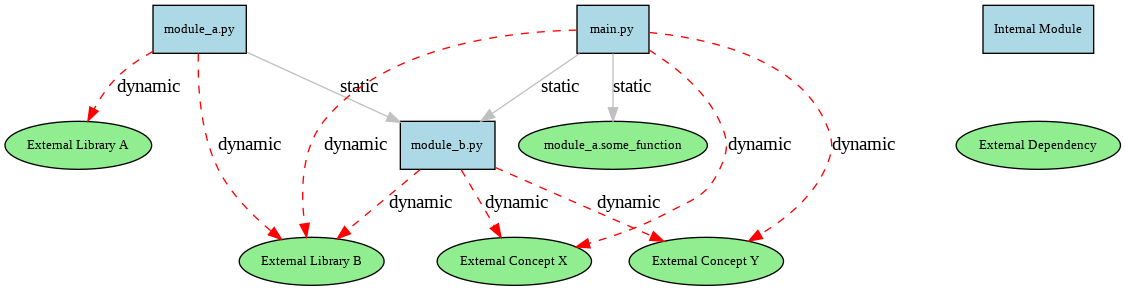

# **TASK 2**

---



In [14]:
import os
import ast
import re
import networkx as nx
from pathlib import Path
from typing import Dict, List, Optional
from together import Together
import json

class CodebaseAnalyzer:
    def __init__(self, directory: str, api_key: Optional[str] = None):
        self.directory = Path(directory)
        self.api_key = api_key or os.environ.get("TOGETHER_API_KEY")
        self.together_client = Together(api_key=self.api_key) if self.api_key else None
        self.module_mapping = {}
        self.package_structure = {}

    def analyze(self, max_files: int = None, skip_llm: bool = False):
        python_files = self._get_python_files(max_files)
        self._build_package_structure(python_files)

        static_dependencies = {}
        for file in python_files:
            imports, exports = self._extract_static_imports_and_exports(file)
            static_dependencies[file] = {'imports': imports, 'exports': exports}

        llm_dynamic_dependencies = {}
        if not skip_llm and self.together_client:
            for file in python_files:
                with open(file, 'r', encoding='utf-8', errors='ignore') as f:
                    code = f.read()
                dynamic_analysis = self._analyze_with_llm(code)
                llm_dynamic_dependencies[file] = dynamic_analysis

        G = self._build_dependency_graph(static_dependencies, llm_dynamic_dependencies)
        return G

    def _get_python_files(self, max_files: Optional[int] = None) -> List[str]:
        python_files = []
        skip_dirs = {'.git', '.venv', 'venv', 'env', '__pycache__', 'node_modules', 'dist', 'build'}

        for root, dirs, files in os.walk(self.directory):
            dirs[:] = [d for d in dirs if d not in skip_dirs]
            for file in files:
                if file.endswith('.py'):
                    file_path = os.path.join(root, file)
                    python_files.append(file_path)
                    if max_files and len(python_files) >= max_files:
                        return python_files
        return python_files

    def _build_package_structure(self, python_files: List[str]) -> None:
        base_dir = str(self.directory)
        for file_path in python_files:
            if os.path.basename(file_path) == "__init__.py":
                rel_path = os.path.relpath(os.path.dirname(file_path), base_dir)
                package_name = rel_path.replace(os.sep, '.')
                self.module_mapping[package_name] = file_path
                parts = package_name.split('.')
                for i in range(1, len(parts) + 1):
                    partial_pkg = '.'.join(parts[:i])
                    if partial_pkg not in self.module_mapping:
                        self.module_mapping[partial_pkg] = file_path
            else:
                rel_path = os.path.relpath(file_path, base_dir)
                module_path = os.path.splitext(rel_path)[0].replace(os.sep, '.')
                self.module_mapping[module_path] = file_path

    def _extract_static_imports_and_exports(self, filepath: str) -> Tuple[List[str], List[str]]:
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
            try:
                code = file.read()
                tree = ast.parse(code)
            except SyntaxError:
                print(f"Syntax error in {filepath}, skipping")
                return [], []

        imports = []
        exports = []

        for node in ast.walk(tree):
            if isinstance(node, ast.Import):
                for alias in node.names:
                    imports.append(alias.name)
            elif isinstance(node, ast.ImportFrom):
                module = node.module or ''
                for alias in node.names:
                    if alias.name == '*':
                        imports.append(f"{module}.*")
                    else:
                        imports.append(f"{module}.{alias.name}")

        for node in ast.iter_child_nodes(tree):
            if isinstance(node, ast.FunctionDef):
                exports.append(node.name)
            elif isinstance(node, ast.ClassDef):
                exports.append(node.name)
            elif isinstance(node, ast.Assign):
                for target in node.targets:
                    if isinstance(target, ast.Name):
                        exports.append(target.id)

        return imports, exports

    def _analyze_with_llm(self, code: str) -> List[str]:
        if not self.together_client:
            return []

        prompt = f"""Analyze this Python code and identify:
1. Any dynamic imports (using importlib, __import__, exec, etc.)
2. Any implicit dependencies not visible in static imports
3. Any complex dependencies hidden in string literals or config files

Only list the actual module names, one per line. If none, respond with "None".

```python
{code}
```"""

        try:
            response = self.together_client.chat.completions.create(
                model="meta-llama/Llama-3-8b-chat-hf",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=1000
            )
            result = response.choices[0].message.content

            dynamic_deps = []
            for line in result.split('\n'):
                clean_line = re.sub(r'^[•\-*\d.\s]+', '', line.strip())
                if clean_line and "None" not in clean_line and len(clean_line) > 2:
                    match = re.search(r'([a-zA-Z0-9_\.]+)', clean_line)
                    if match:
                        module = match.group(1)
                        dynamic_deps.append(module)

            return dynamic_deps
        except Exception as e:
            print(f"Error in LLM analysis: {e}")
            return []

    def _build_dependency_graph(self, static_data: Dict, llm_data: Dict) -> nx.DiGraph:
        G = nx.DiGraph()

        for file in static_data.keys():
            rel_path = os.path.relpath(file, self.directory)
            G.add_node(rel_path, type="file", exports=static_data[file]['exports'])

        for file, data in static_data.items():
            rel_path = os.path.relpath(file, self.directory)
            for imported_module in data['imports']:
                resolved_file = self._resolve_import(file, imported_module)
                if resolved_file:
                    rel_import = os.path.relpath(resolved_file, self.directory)
                    G.add_edge(rel_path, rel_import, type="static")
                else:
                    G.add_node(imported_module, type="external")
                    G.add_edge(rel_path, imported_module, type="static")

        for file, dynamic_deps in llm_data.items():
            rel_path = os.path.relpath(file, self.directory)
            for module in dynamic_deps:
                resolved_file = self._resolve_import(file, module)
                if resolved_file:
                    rel_import = os.path.relpath(resolved_file, self.directory)
                    G.add_edge(rel_path, rel_import, type="dynamic")
                else:
                    if module not in G.nodes():
                        G.add_node(module, type="external")
                    G.add_edge(rel_path, module, type="dynamic")

        return G

    def _resolve_import(self, importing_file: str, imported_module: str) -> Optional[str]:
        if imported_module in self.module_mapping:
            return self.module_mapping[imported_module]

        if imported_module.startswith('.'):
            importing_dir = os.path.dirname(importing_file)
            rel_level = 0
            while imported_module.startswith('.'):
                imported_module = imported_module[1:]
                rel_level += 1

            current_dir = importing_dir
            for _ in range(rel_level - 1):
                current_dir = os.path.dirname(current_dir)

            if imported_module:
                potential_file = os.path.join(current_dir, *imported_module.split('.')) + '.py'
                if os.path.exists(potential_file):
                    return potential_file
                potential_init = os.path.join(current_dir, *imported_module.split('.'), '__init__.py')
                if os.path.exists(potential_init):
                    return potential_init
            else:
                potential_init = os.path.join(current_dir, '__init__.py')
                if os.path.exists(potential_init):
                    return potential_init

        base_path = str(self.directory)
        potential_file = os.path.join(base_path, *imported_module.split('.')) + '.py'
        if os.path.exists(potential_file):
            return potential_file

        potential_init = os.path.join(base_path, *imported_module.split('.'), '__init__.py')
        if os.path.exists(potential_init):
            return potential_init

        return None

class CodeSummarizerAgent:
    def __init__(self, directory: str, api_key: Optional[str] = None):
        self.directory = Path(directory)
        self.api_key = api_key or os.environ.get("TOGETHER_API_KEY")
        self.together_client = Together(api_key=self.api_key) if self.api_key else None
        self.analyzer = CodebaseAnalyzer(directory, api_key)

    def summarize_codebase(self, max_files: int = None, skip_llm: bool = False):
        G = self.analyzer.analyze(max_files=max_files, skip_llm=skip_llm)
        summaries = {}
        for node, attrs in G.nodes(data=True):
            if attrs.get('type') == 'file':
                file_path = os.path.join(self.directory, node)
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    code = f.read()
                summaries[node] = self._summarize_module(code, attrs.get('exports', []))
        return summaries

    def _summarize_module(self, code: str, exports: List[str]) -> Dict[str, str]:
        summaries = {}
        for export in exports:
            prompt = f"""Summarize the following code and explain what the {export} function/class does.
Provide a structured explanation including its purpose, dependencies, and usage within the project.

Code:
```python
{code}
```"""
            summary = self._query_llm(prompt)
            summaries[export] = summary
        return summaries

    def _query_llm(self, prompt: str) -> str:
        if not self.together_client:
            return "LLM not available"
        try:
            response = self.together_client.chat.completions.create(
                model="meta-llama/Llama-3-8b-chat-hf",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=1000
            )
            return response.choices[0].message.content
        except Exception as e:
            print(f"Error in LLM query: {e}")
            return ""

# Example usage
if __name__ == "__main__":
    codebase_directory = "/content/test_code"  # Path to your codebase
    api_key = "a487475c3bd8d69e39ee699f5b72cfeb5a0d3385866fd24182b96830131212d2"  # Your Together.ai API key

    print(f"Analyzing codebase in {codebase_directory}...")

    agent = CodeSummarizerAgent(codebase_directory, api_key)
    summaries = agent.summarize_codebase(max_files=50)

    for module, summary in summaries.items():
        print(f"Module: {module}")
        for func, desc in summary.items():
            print(f"  Function/Class: {func}")
            print(f"  Summary: {desc}")
            print()

    print("Analysis complete!")


Analyzing codebase in /content/test_code...
Module: module_a.py
  Function/Class: some_function
  Summary: **Summary**

The code defines a single function `some_function` in a Python module named `module_a`. This module also imports another module named `module_b`.

**Purpose**

The purpose of `some_function` is not explicitly defined in the code, as it is currently a "pass" statement, which means it does nothing. However, in a real-world scenario, this function would likely perform some specific task or operation.

**Dependencies**

The `module_a` module depends on `module_b`, which means that `module_a` uses or references something from `module_b`. The exact nature of this dependency is not clear from the provided code, but it could be a function, variable, or class from `module_b`.

**Usage within the project**

Without more context, it's difficult to determine how `some_function` would be used within the project. However, here are a few possible scenarios:

1. **Module-level functi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')